<a href="https://colab.research.google.com/github/machiwao/CCTHESS1-CCTHESS2-Dev-and-Docs/blob/eco/ToDrive_NDVI_data_scraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import ee
import geemap
import pandas as pd

In [2]:
cloud_project = 'midyear-forest-427007-s7'

try:
  ee.Initialize(project=cloud_project)
except:
  ee.Authenticate()
  ee.Initialize(project=cloud_project)

stations = {
    "PortArea": ee.Geometry.Point([120.967866, 14.58841]).buffer(25000),
    "ScienceGarden": ee.Geometry.Point([121.044282, 14.645072]).buffer(25000),
    "SangleyPoint": ee.Geometry.Point([120.906838, 14.494953]).buffer(25000),
    "PuertoPrinsesa": ee.Geometry.Point([118.758613, 9.740134]).buffer(25000),
    "SanJose": ee.Geometry.Point([121.04788, 12.359602]).buffer(25000),
}

start_date = "2014-01-01"
end_date   = "2024-01-01"

In [3]:
def process_station(station_name, geometry, start_date, end_date):
    """
    Extract and process NDVI from VIIRS CDR dataset with scaling and interpolation.

    Dataset: NOAA/CDR/VIIRS/NDVI/V1
    Docs: https://developers.google.com/earth-engine/datasets/catalog/NOAA_CDR_VIIRS_NDVI_V1
    Scale factor: 0.0001
    Valid range: -1 to 1
    Native resolution: ~5566m
    """

    viirs_ndvi = ee.ImageCollection("NOAA/CDR/VIIRS/NDVI/V1").filterBounds(geometry).filterDate(start_date, end_date)

    print(f"Processing NDVI for {station_name}...")

    def extract_values(img):
        date = ee.Date(img.get('system:time_start')).format('YYYY-MM-dd')

        ndvi = img.select('NDVI').multiply(0.0001)  # apply scale factor
        ndvi = ndvi.updateMask(ndvi.gte(-1).And(ndvi.lte(1)))

        stats = ndvi.reduceRegion(
            reducer=ee.Reducer.mean(),
            geometry=geometry,
            scale=5566,
            bestEffort=True,
            maxPixels=1e9
        )

        return ee.Feature(None, stats).set('date', date)

    # Map and convert
    features = viirs_ndvi.map(extract_values)
    df = geemap.ee_to_df(ee.FeatureCollection(features))

    if df.empty:
        print(f"No NDVI data for {station_name}")
        return df

    # Process timeseries
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date").groupby("date").mean().reset_index()

    full_range = pd.date_range(start=start_date, end=end_date, freq="D")
    g = df.set_index("date").reindex(full_range).reset_index().rename(columns={"index": "date"})

    g["NDVI_original"] = g["NDVI"]
    g["NDVI_linear"] = g["NDVI"].interpolate("linear", limit_direction="both")
    g["NDVI_spline"] = g["NDVI"].interpolate("spline", order=2, limit_direction="both")

    out_file = f"{station_name}_NDVI.csv"
    g[["date", "NDVI_original", "NDVI_linear", "NDVI_spline"]].to_csv(out_file, index=False)

    print(f"Saved {out_file} ({g.shape[0]} rows)")
    return g


In [4]:
all_dfs = {}
for station, geom in stations.items():
    all_dfs[station] = process_station(station, geom, start_date, end_date)

Processing NDVI for PortArea...
Saved PortArea_NDVI.csv (3653 rows)
Processing NDVI for ScienceGarden...
Saved ScienceGarden_NDVI.csv (3653 rows)
Processing NDVI for SangleyPoint...
Saved SangleyPoint_NDVI.csv (3653 rows)
Processing NDVI for PuertoPrinsesa...
Saved PuertoPrinsesa_NDVI.csv (3653 rows)
Processing NDVI for SanJose...
Saved SanJose_NDVI.csv (3653 rows)


In [5]:
# Check the first few rows of one of the dataframes
if all_dfs:
    first_station = list(all_dfs.keys())[0]
    print(f"First values for {first_station}:")
    display(all_dfs[first_station].head())
else:
    print("No dataframes were processed.")

First values for PortArea:


,date,NDVI,NDVI_original,NDVI_linear,NDVI_spline
0,2014-01-01,0.413519,0.413519,0.413519,0.413519
1,2014-01-02,0.319176,0.319176,0.319176,0.319176
2,2014-01-03,0.430751,0.430751,0.430751,0.430751
3,2014-01-04,0.381138,0.381138,0.381138,0.381138
4,2014-01-05,0.126695,0.126695,0.126695,0.126695


Mounted at /content/drive
Saved PortArea_NDVI.csv to /content/drive/MyDrive/Jerico_Datasets/NDVI/PortArea_NDVI.csv


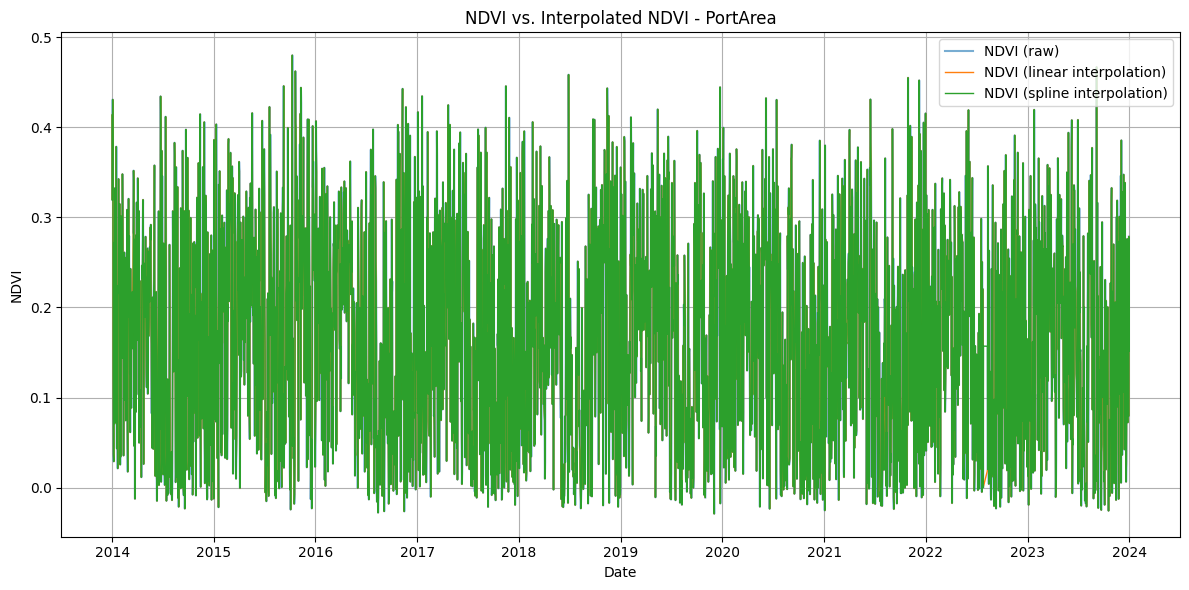

Saved ScienceGarden_NDVI.csv to /content/drive/MyDrive/Jerico_Datasets/NDVI/ScienceGarden_NDVI.csv


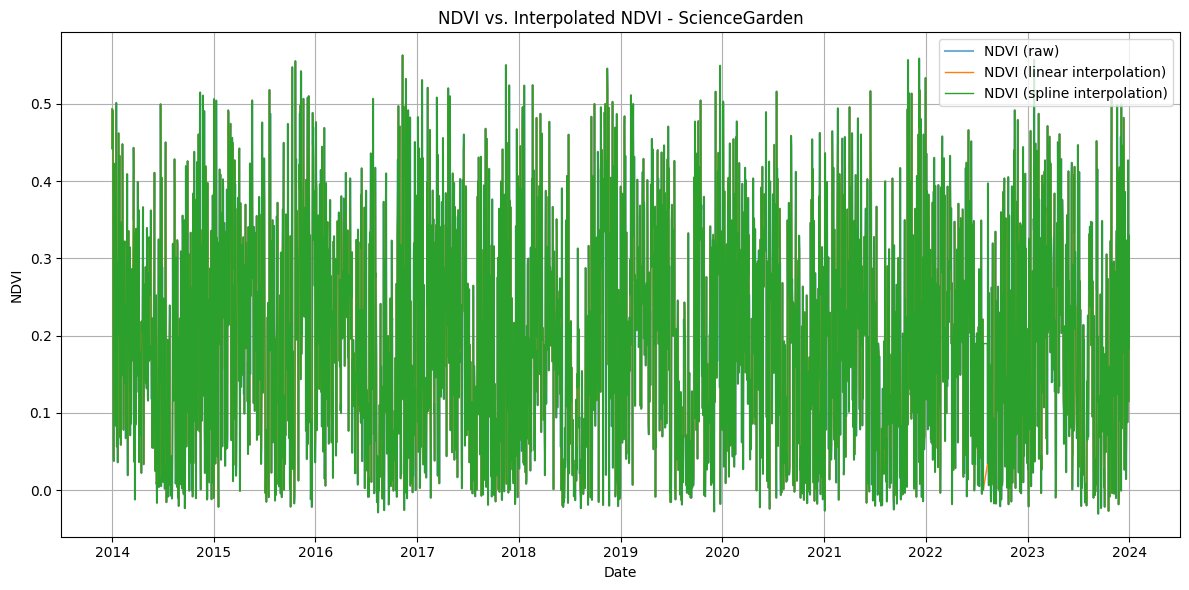

Saved SangleyPoint_NDVI.csv to /content/drive/MyDrive/Jerico_Datasets/NDVI/SangleyPoint_NDVI.csv


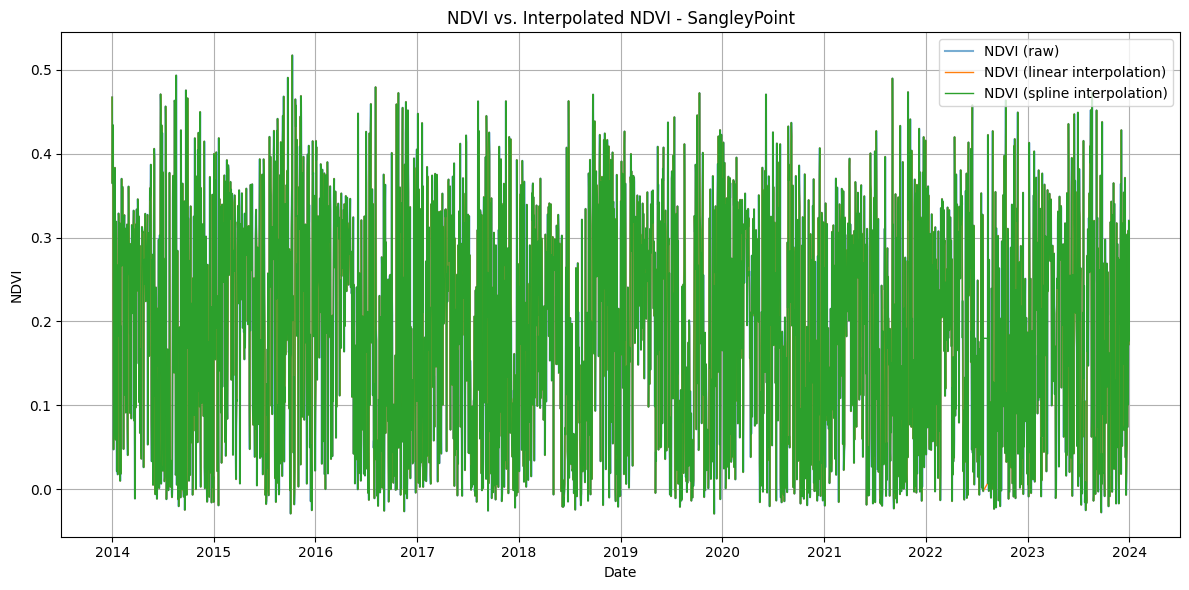

Saved PuertoPrinsesa_NDVI.csv to /content/drive/MyDrive/Jerico_Datasets/NDVI/PuertoPrinsesa_NDVI.csv


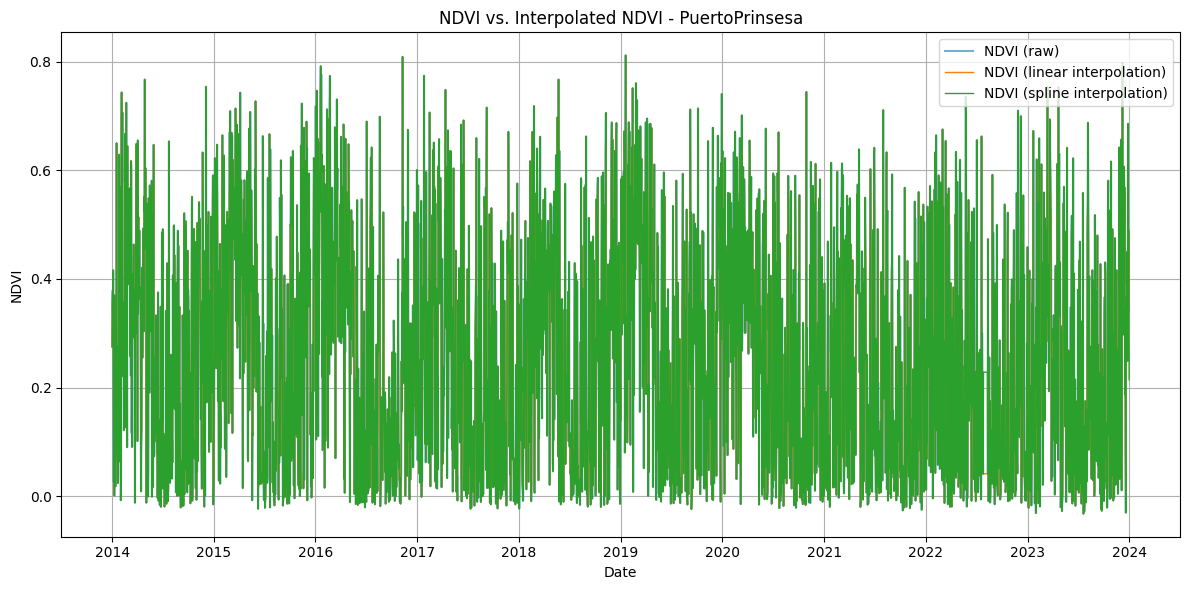

Saved SanJose_NDVI.csv to /content/drive/MyDrive/Jerico_Datasets/NDVI/SanJose_NDVI.csv


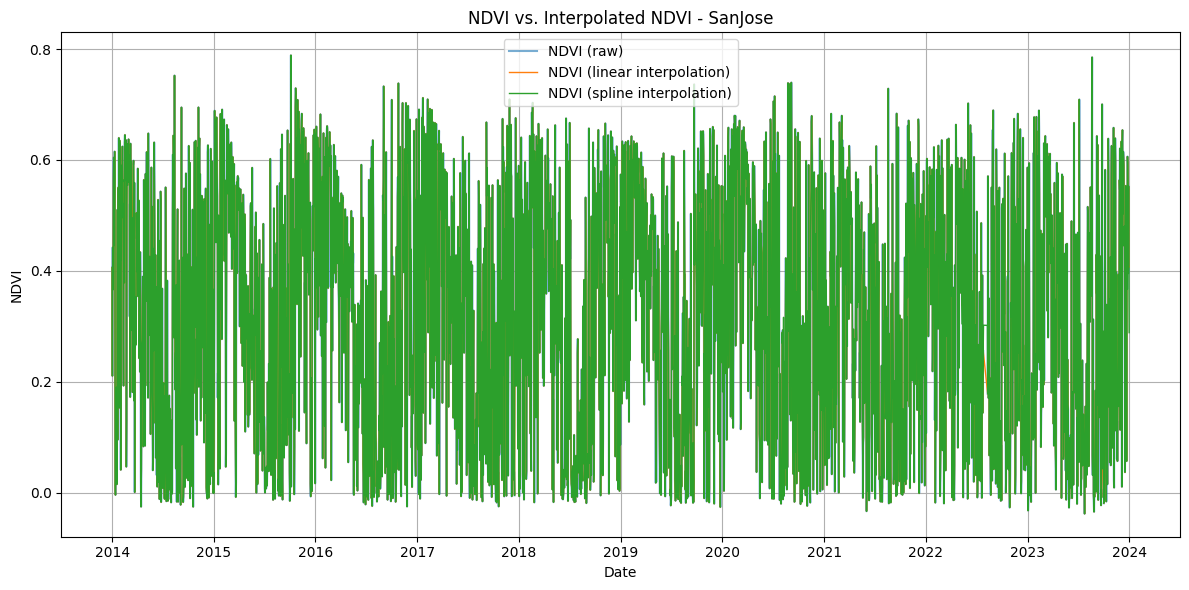

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Define the path to your Google Drive folder where you want to save CSV files
# Change this path to match your desired folder structure
GDRIVE_PATH = '/content/drive/MyDrive/Jerico_Datasets/NDVI'

# Create the directory if it doesn't exist
os.makedirs(GDRIVE_PATH, exist_ok=True)

def save_csv_to_drive(df, filename, gdrive_path):
    """Save DataFrame to Google Drive"""
    full_path = os.path.join(gdrive_path, filename)
    df.to_csv(full_path, index=False)
    print(f"Saved {filename} to {full_path}")

def plot_values(csv_file, station_name, save_to_drive=True):
    """
    Load CSV and plot NDVI values
    If save_to_drive is True, also save a copy to Google Drive
    """
    # Load CSV (expects columns: date, NDVI_original, NDVI_linear, NDVI_spline)
    df = pd.read_csv(csv_file, parse_dates=["date"])

    # Save to Google Drive if requested
    if save_to_drive:
        save_csv_to_drive(df, csv_file, GDRIVE_PATH)

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df["date"], df["NDVI_original"], label="NDVI (raw)", alpha=0.6)
    plt.plot(df["date"], df["NDVI_linear"], label="NDVI (linear interpolation)", linewidth=1)
    plt.plot(df["date"], df["NDVI_spline"], label="NDVI (spline interpolation)", linewidth=1)

    plt.xlabel("Date")
    plt.ylabel("NDVI")
    plt.title(f"NDVI vs. Interpolated NDVI - {station_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Alternative: Direct save to Google Drive function
def save_existing_csvs_to_drive():
    """Save existing CSV files from Colab to Google Drive"""
    station_names = ["PortArea", "ScienceGarden", "SangleyPoint", "PuertoPrinsesa", "SanJose"]

    for station in station_names:
        csv_file = f"{station}_NDVI.csv"

        # Check if file exists in current directory
        if os.path.exists(csv_file):
            # Read the CSV
            df = pd.read_csv(csv_file)
            # Save to Google Drive
            save_csv_to_drive(df, csv_file, GDRIVE_PATH)
        else:
            print(f"Warning: {csv_file} not found in current directory")

# Method 1: Run your existing code but also save to Google Drive
station_names = ["PortArea", "ScienceGarden", "SangleyPoint", "PuertoPrinsesa", "SanJose"]
for station in station_names:
    csv_file = f"{station}_NDVI.csv"
    plot_values(csv_file, station, save_to_drive=True)

# Method 2: If you just want to save existing CSV files without plotting
# Uncomment the line below to use this method instead
# save_existing_csvs_to_drive()